In [67]:
import sys, os, ndreg, skimage
import matplotlib.pyplot as plt
from matplotlib import cm
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import missing_data_sim as mdmask

In [68]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

## Visualization methods

In [69]:
def get_img_grid(img, cmap='Greys'):
    numSlices = 3
    size = img.GetSize()
    ret = []
    for i in range(img.GetDimension()):
        start = size[2 - i] / (numSlices + 1)
        sliceList = np.linspace(start, size[2 - i] - start, numSlices)
        sliceSize = list(size)
        sliceSize[2 - i] = 0

        for (j, slice) in enumerate(sliceList):
            sliceIndex = [0] * img.GetDimension()
            sliceIndex[2 - i] = int(slice)
            sliceImg = sitk.Extract(img, sliceSize, sliceIndex)
            sliceArray = sitk.GetArrayFromImage(sliceImg)
            ret.append(sliceArray)
    return ret

# Setup Data

In [70]:
resolution = 50

In [71]:
rmt = BossRemote(cfg_file_or_dict='./intern.cfg')
atlas = ndreg.download_ara(rmt, resolution)

In [72]:
atlas_mask = preprocessor.create_mask(atlas, use_triangle=True)

In [73]:
img = sitk.Image(atlas)
img_mask = preprocessor.create_mask(img, use_triangle=True)
width, height, depth = atlas.GetSize()

In [74]:
annotations = ndreg.download_ara(rmt, resolution, type='annotation')

## Create the Missing data masks

In [89]:
# Generates a random half space in the image space
rand_halfspace_array = mdmask.gen_random_halfspace(depth, height, width)
# Mask that cuts the image space exactly in half
hemisphere_array = mdmask.gen_hemisphere_mask(depth, height, width)
# Mask of just the olfactory bulb
olf_bulb_layers = [507, 212, 220, 228, 236, 244, 151, 188, 196, 204]
olf_bulb_array = mdmask.gen_label_mask(annotations, atlas_mask, olf_bulb_layers)


In [90]:
rand_halfspace_mask = mdmask.convert_to_image(rand_halfspace_array.astype('uint16'))
hemisphere_mask = mdmask.convert_to_image(hemisphere_array.astype('uint16'))
olf_bulb_mask = mdmask.convert_to_image(olf_bulb_array.astype('uint16'))


In [91]:
rand_halfspace_mask.CopyInformation(img)
hemisphere_mask.CopyInformation(img)
olf_bulb_mask.CopyInformation(img)
# DAFUQ when a method doesn't do what it says

In [92]:
atlas_rh = mdmask.mask_img(img, rand_halfspace_mask)
atlas_hemi = mdmask.mask_img(img, hemisphere_mask)
atlas_olf = mdmask.mask_img(img, olf_bulb_mask)

In [93]:
rh_grid = get_img_grid(atlas_rh)
hemi_grid = get_img_grid(atlas_hemi)
olf_grid = get_img_grid(atlas_olf)
orig_grid = get_img_grid(atlas)

In [94]:
grids = [orig_grid,rh_grid, hemi_grid, olf_grid]
grid_titles = ['Orig', 'Random Affine', 'Half Hemi', 'Olf bulb']
row_len = len(grids[0])
col_len = len(grids)

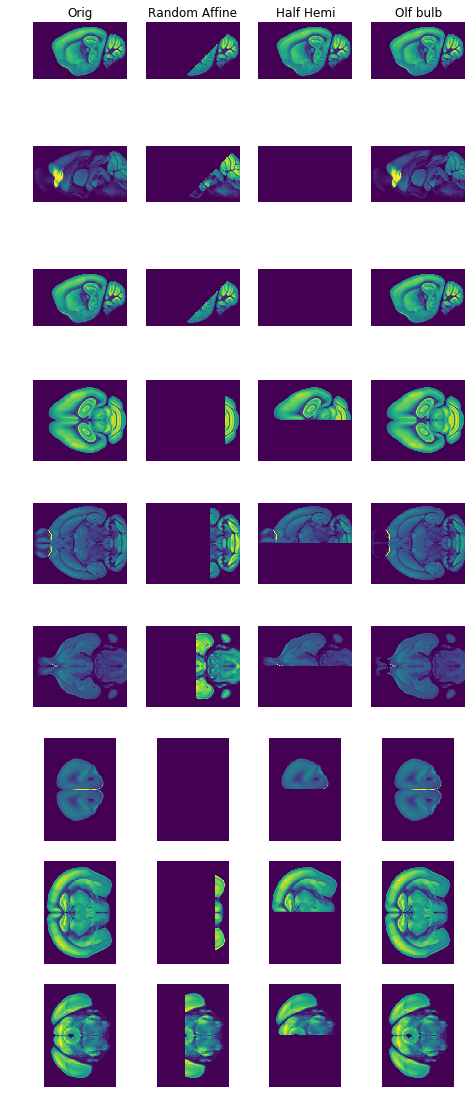

In [95]:
import matplotlib.gridspec as gridspec
plt.clf()
fig = plt.figure(figsize=(40,20))
gs1 = gridspec.GridSpec(
    nrows=row_len, 
    ncols=col_len, 
    left=0.1,
    right=0.25,
)
for i,grid in enumerate(grids):
    for k in range(row_len):
        ax = plt.subplot(gs1[(i+1)+(col_len*k)-1])
        plt.axis('off')
        ax.set_aspect('equal')
        plt.imshow(grid[k])
        if not k:
            ax.set_title(grid_titles[i])
plt.savefig("masked_atlases.png")

# Registration step by step

## Set source and target images

In [20]:
atlas = ndreg.download_ara(rmt, 50)
img = atlas_hemi
img = ndreg.download_image(rmt, 'ailey-dev', 'Insula_Atenolol-1_171204_new', 'Ch0', res=3)

In [21]:
atlas_hemi.SetSpacing((0.05,0.05,0.05))

## Create masks

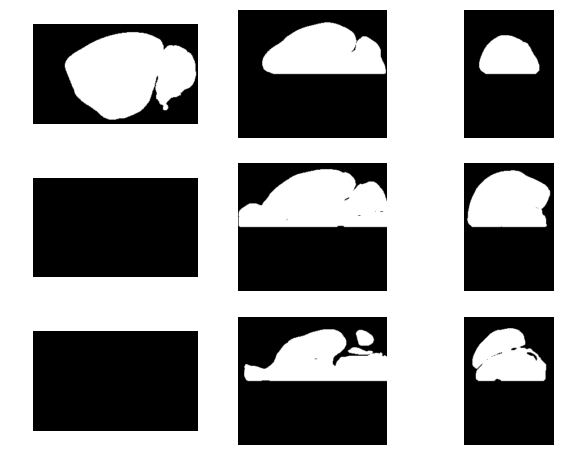

In [22]:
mask_sitk = preprocessor.create_mask(img, use_triangle=True)
ndreg.imgShow(mask_sitk, vmax=1)

### Correct Bias field

In [23]:
# img_bc = preprocessor.correct_bias_field(img, scale=0.1, mask=mask_sitk,
#                                          spline_order=4, num_control_pts=[5,5,5],
#                                          niters=[200, 200, 100, 50])

In [24]:
# ndreg.imgShow(img_bc)

In [25]:
# ndreg.imgShow(atlas)

# Resampling Images

In [26]:
# atlas_ds, img_bc_ds = preprocessor.downsample_and_reorient(atlas, img, "lps", "lps", 1.0)


In [27]:
# img_bc_ds = sitk.Normalize(img_bc_ds)
# atlas_ds = sitk.Normalize(atlas)
# # atlas_ds, img_bc_ds = preprocessor.downsample_and_reorient(img_bc, atlas, "pir", "lps", 0.05, default_value=ndreg.imgPercentile(img_bc, 0.01))

In [28]:
# img_bc_ds = sitk.Normalize(img_bc_ds)
# atlas_ds = sitk.Normalize(atlas_ds)

### Skipping resampling and bias correction... Doing more harm than good

In [29]:
atlas_ds = sitk.Normalize(atlas)
img_bc_ds = sitk.Normalize(img)

# atlas_ds = atlas
# img_bc_ds = img

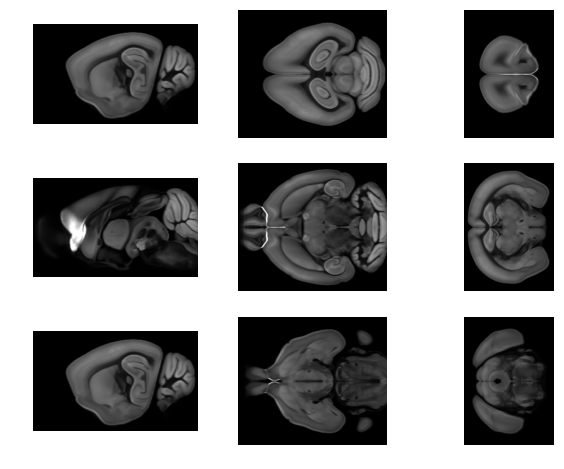

In [30]:
ndreg.imgShow(atlas_ds)

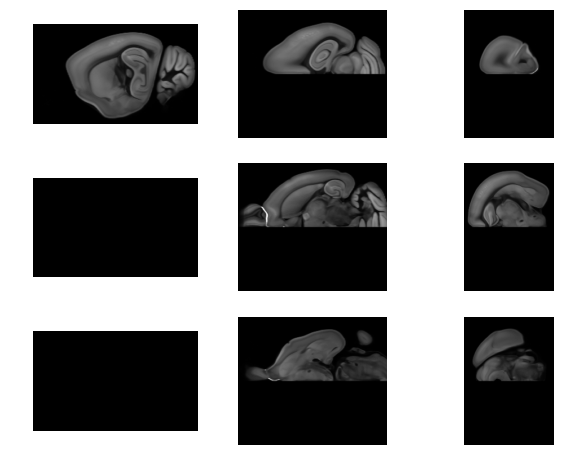

In [31]:
ndreg.imgShow(img_bc_ds)

In [32]:
stats = sitk.StatisticsImageFilter()
stats.Execute(img_bc_ds)
stats.GetMaximum()

7.687246012441087

# Registration part

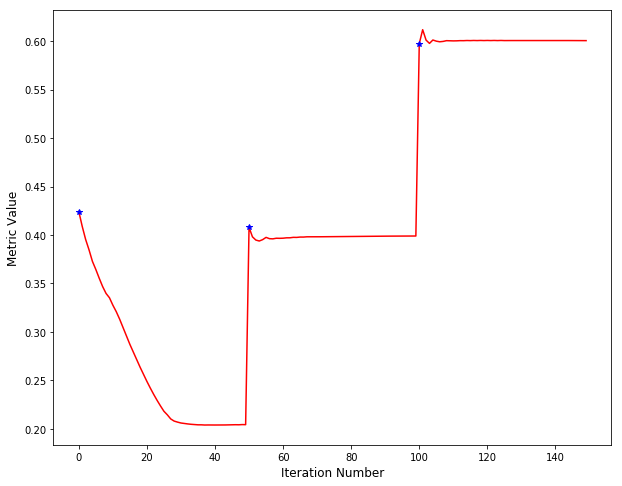

In [33]:
final_transform = registerer.register_affine(atlas_ds, 
                                            img_bc_ds,
                                            learning_rate=1e-1,
                                            grad_tol=4e-6,
                                            use_mi=False,
                                            iters=50,
                                            shrink_factors=[4,2,1],
                                            sigmas=[0.6, 0.3, 0.150],
                                            verbose=True)

In [34]:
out_atlas = registerer.resample(atlas_ds, final_transform, atlas_ds)
out_target = registerer.resample(img_bc_ds, final_transform.GetInverse(), img_bc_ds)

# out_target = sitk.Resample(img_bc_ds, img_bc_ds, final_transform,
#                          sitk.sitkCosineWindowedSinc, 0.0)
                                 

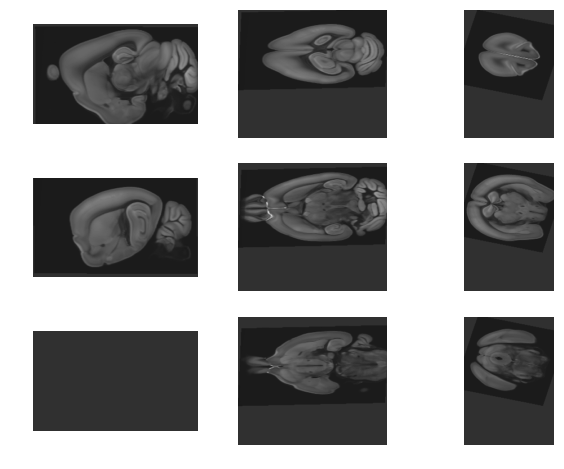

In [35]:
ndreg.imgShow(out_atlas)

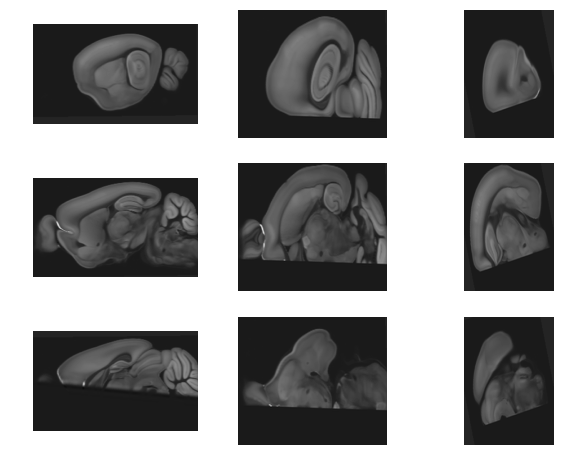

In [36]:
ndreg.imgShow(out_target)

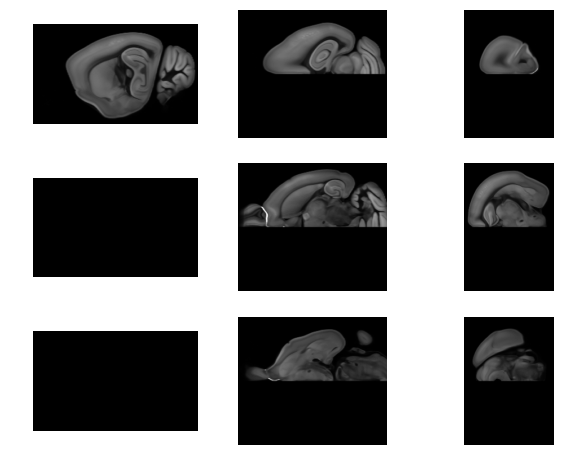

In [37]:
ndreg.imgShow(img_bc_ds)

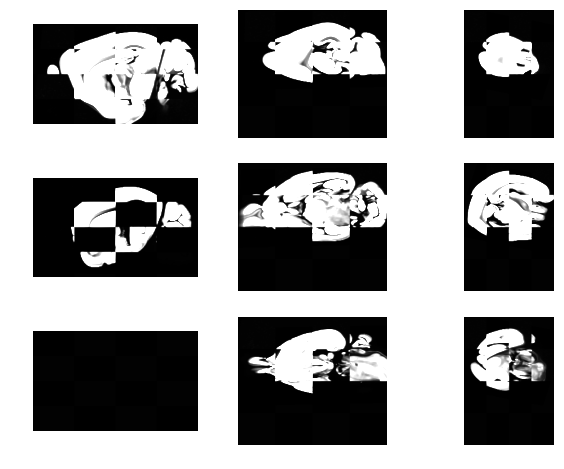

In [38]:
ndreg.imgShow(ndreg.imgChecker(out_atlas, img_bc_ds), vmax=1)

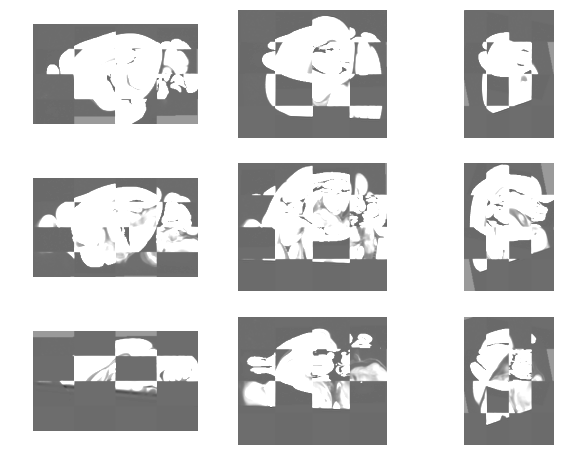

In [39]:
ndreg.imgShow(ndreg.imgChecker(out_atlas, out_target), vmax=1)

In [40]:
atlas_kernel = [5,5,5]

In [42]:
out_atlas_whitened = preprocessor.whiten(out_atlas, radius=atlas_kernel)
img_bc_ds_whitened = preprocessor.whiten(img_bc_ds, radius=atlas_kernel)

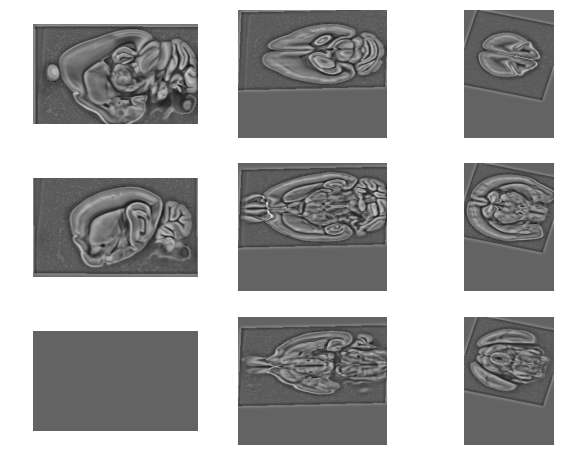

In [43]:
ndreg.imgShow(out_atlas_whitened)

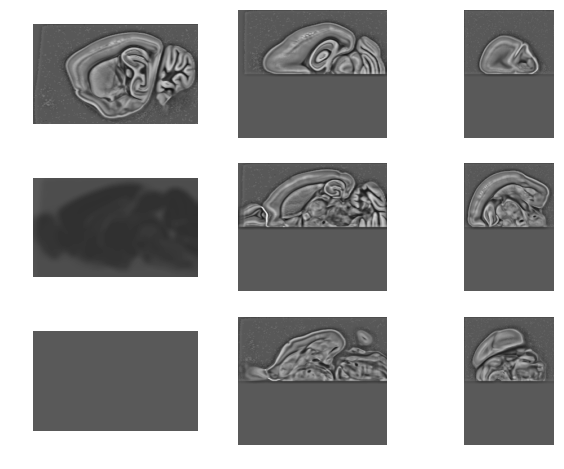

In [44]:
ndreg.imgShow(img_bc_ds_whitened)

## lddmm

In [46]:
atlas_lddmm, field, inv_field = registerer.register_lddmm(affine_img=sitk.Normalize(out_atlas_whitened), 
                                                          target_img=sitk.Normalize(img_bc_ds_whitened),
                                                          alpha_list=[0.02], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=1e-3, sigma=0.008,
                                                          min_epsilon_list=1e-10,
                                                          use_mi=False, iterations=50, verbose=True)


Step 0: alpha=0.02, beta=0.05, scale=0.0625
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	1.60897e+07, 78146.6, 0, 1.60116e+07 (81.6705%), 1.375000e-04
1.	1.48413e+07, 94512, 0, 1.47468e+07 (75.2193%), 1.512500e-04
2.	1.42793e+07, 94588.1, 0, 1.41847e+07 (72.3523%), 2.079688e-05
3.	1.4132e+07, 95176.4, 0, 1.40369e+07 (71.5981%), 2.287656e-05
E = 1.4132e+07 (71.5981%)
Length = 398.832
Time = 16.9409s (0.282348m)

Step 1: alpha=0.02, beta=0.05, scale=0.125
	E, E_velocity, E_rate, E_image (E_image %), LearningRate
0.	1.13014e+07, 97829.3, 0, 1.12035e+07 (87.0204%), 1.100000e-03
1.	1.10772e+07, 147798, 0, 1.09294e+07 (84.8909%), 1.210000e-03
2.	1.09361e+07, 196683, 0, 1.07394e+07 (83.4152%), 1.331000e-03
3.	1.08322e+07, 222404, 0, 1.06098e+07 (82.4086%), 1.464100e-03
4.	1.08206e+07, 248554, 0, 1.0572e+07 (82.1154%), 8.052550e-04
5.	1.07939e+07, 248245, 0, 1.05456e+07 (81.9103%), 2.768064e-05
E = 1.07939e+07 (81.9103%)
Length = 649.744
Time = 21.8547s (0.364245m)

Step 2: al

Length = 22.2557
Time = 2464.83s (41.0804m)


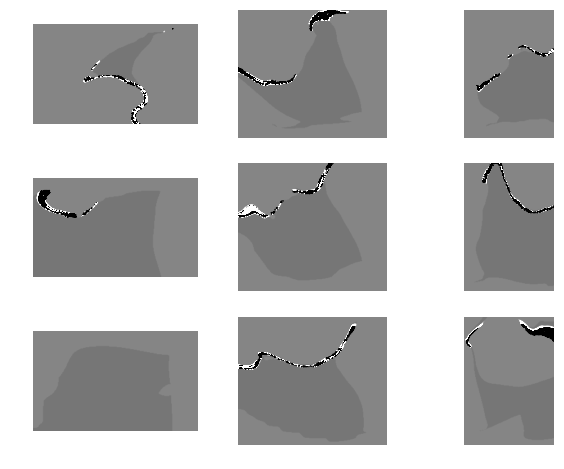

In [66]:
ndreg.imgShow(sitk.Normalize(atlas_lddmm), vmin=-1, vmax=1)

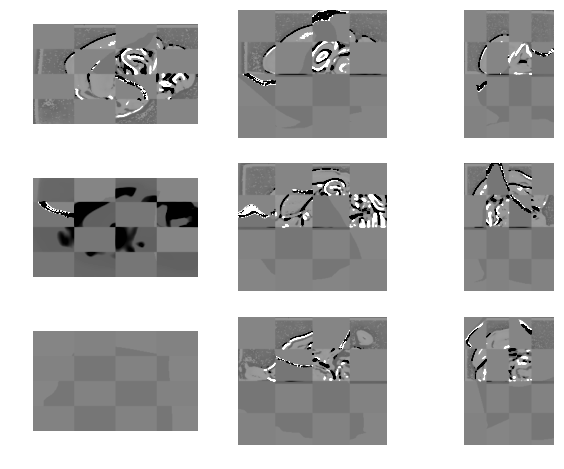

In [64]:
ndreg.imgShow(ndreg.imgChecker(sitk.Normalize(img_bc_ds_whitened), sitk.Normalize(atlas_lddmm)), vmin=-1, vmax=1)
              

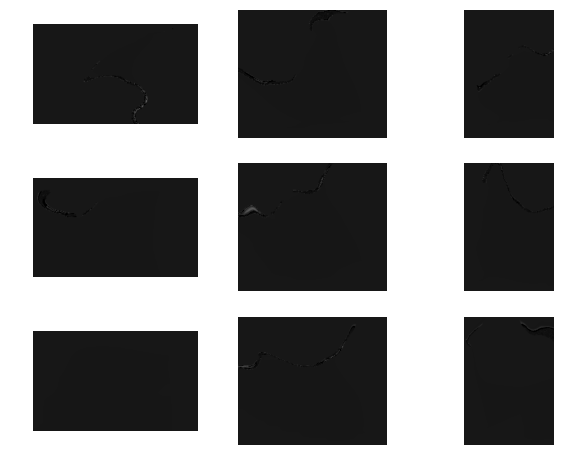

In [60]:
ndreg.imgShow(atlas_lddmm, vmax=10, vmin=-1)

# Registration all-in-one cell!

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

import sys
import ndreg
from ndreg import preprocessor, registerer
import SimpleITK as sitk
import numpy as np
from intern.remote.boss import BossRemote
from intern.resource.boss.resource import *
import skimage

import os

### Step 1: Load data

rmt = BossRemote(cfg_file_or_dict='./intern.cfg')

# img = ndreg.download_image(rmt, 'ailey-dev', 'Insula_Atenolol-1_171204_new', 'Ch0', res=3)
img = ndreg.download_ara(rmt, 100)

# download atlas

atlas = atlas_rh
# atlas = atlas_hemi
# atlas = atlas_olf

## create the mask

mask_sitk = preprocessor.create_mask(img, use_triangle=True)

ndreg.imgShow(mask_sitk, vmax=1)

### Correct Bias field

img_bc = preprocessor.correct_bias_field(img, scale=0.25, mask=mask_sitk,
                                         spline_order=4, num_control_pts=[5,5,5],
                                         niters=[200, 200, 100, 50])

ndreg.imgShow(img_bc, vmax=2500)

ndreg.imgShow(atlas)

# Resampling Images

atlas_ds, img_bc_ds = preprocessor.downsample_and_reorient(atlas, img_bc, "pir", "lps", 0.05)

ndreg.imgShow(atlas_ds)

ndreg.imgShow(img_bc_ds, vmax=2000)

img_bc_ds = sitk.Normalize(img_bc_ds)
atlas_ds = sitk.Normalize(atlas_ds)

# Registration part

final_transform = registerer.register_affine(atlas_ds, 
                                            img_bc_ds,
                                            learning_rate=1e-1,
                                            grad_tol=4e-6,
                                            use_mi=False,
                                            iters=50,
                                            shrink_factors=[4,2,1],
                                            sigmas=[0.6, 0.3, 0.150],
                                            verbose=True)

out_atlas = registerer.resample(atlas_ds, final_transform, atlas_ds)
out_target = registerer.resample(img_bc_ds, final_transform.GetInverse(), img_bc_ds)

ndreg.imgShow(out_atlas)

ndreg.imgShow(out_target)

ndreg.imgShow(ndreg.imgChecker(out_atlas, img_bc_ds), vmax=1)

whiten_radius = [5,5,5]
out_target_whitened = preprocessor.whiten(out_target, radius=whiten_radius)
atlas_ds_whitened = preprocessor.whiten(atlas_ds, radius=whiten_radius)

out_atlas_whitened = preprocessor.whiten(out_atlas, radius=whiten_radius)
img_bc_ds_whitened = whiten(img_bc_ds, radius=whiten_radius)

ndreg.imgShow(out_target_whitened)

ndreg.imgShow(out_atlas_whitened, vmax=300)

ndreg.imgShow(img_bc_ds_whitened)

ndreg.imgShow(atlas_ds_whitened)

## lddmm

atlas_lddmm, field, inv_field = registerer.register_lddmm(affine_img=sitk.Normalize(out_atlas2_whitened), 
                                                          target_img=sitk.Normalize(img_bc_ds_whitened),
                                                          alpha_list=[0.02], 
                                                          scale_list = [0.0625, 0.125, 0.25, 0.5, 1.0],
                                                          epsilon_list=1e-3, sigma=0.008,
                                                          min_epsilon_list=1e-10,
                                                          use_mi=False, iterations=300, verbose=True)

ndreg.imgShow(atlas_lddmm)

ndreg.imgShow(ndreg.imgChecker(img_bc_ds_whitened, atlas_lddmm), vmax=1)